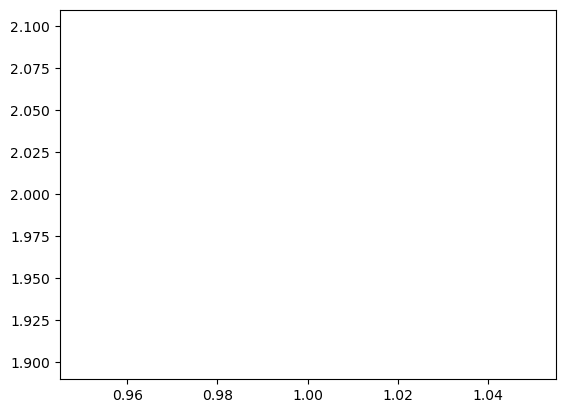

In [1]:
import matplotlib.pyplot as plt
plt.plot([1, 1], [2, 2])

In [2]:
import os
import logging
import argparse
import torch as th

from torch.nn import functional as F
from torch.utils.data import DataLoader

import numpy as np
import torchmetrics

import math
from torch import nn

import contextlib
import numpy as np
import pandas as pd
import networkx as nx
from tqdm.notebook import tqdm

In [3]:
class GraphConvolutionLayer(nn.Module):
    def __init__(self, in_feats, out_feats) -> None:
        super().__init__()

        self.in_feats = in_feats
        self.out_feats = out_feats

        self.weight = nn.Parameter(th.FloatTensor(in_feats, out_feats))
        self.bias = nn.Parameter(th.FloatTensor(out_feats))

        self.reset_parameters()

    def reset_parameters(self):
        stdv = 1. / math.sqrt(self.weight.size(1))
        self.weight.data.uniform_(-stdv, stdv)
        self.bias.data.uniform_(-stdv, stdv)

    def forward(self, x, adj):
#         print(x.shape, self.weight.shape)
        # Здесь может быть проблема!!!! Заменил mm на matmul
        # Добавил приведение к double
#         print(x)
        support = th.matmul(x, self.weight)
        output = th.matmul(adj, support)
        output = output + self.bias

        return output


class GCN(nn.Module):
    def __init__(self, nfeats, nhids, nclasses, dropout=0.5):
        super().__init__()
        
        self.dropout = dropout

        self.conv1 = GraphConvolutionLayer(nfeats, nhids)
        self.conv2 = GraphConvolutionLayer(nhids, nclasses)
    
    def forward(self, x, adj):
        x = F.relu(self.conv1(x, adj))
        x = F.dropout(x, self.dropout, training=self.training)
        x = self.conv2(x, adj)

        return x


class GAE(nn.Module):
    def __init__(self, feature_size, hidden_size, code_size) -> None:
        super().__init__()

        self.hidden_size = hidden_size
        self.code_size = code_size

        self.gcn = GCN(feature_size, hidden_size, code_size)

    def encoder(self, x, adj):
        return self.gcn(x, adj)

    def decoder(self, z):    
        return th.sigmoid(th.matmul(z, z.t()))

    def forward(self, x, adj):
        z = self.encoder(x, adj)
        adj_rec = self.decoder(z)
        return z, adj_rec


class VGAE(nn.Module):
    def __init__(self, feature_size, hidden_size, code_size) -> None:
        super().__init__()

        self.hidden_size = hidden_size
        self.code_size = code_size

        self.gcn = GraphConvolutionLayer(feature_size, hidden_size)

        self.conv_mean = GraphConvolutionLayer(hidden_size, code_size)
        self.conv_log_std = GraphConvolutionLayer(hidden_size, code_size)

    def encoder(self, x, adj):
        hn = self.gcn(x, adj)
        
        self.mean = self.conv_mean(hn, adj)
        self.log_std = self.conv_log_std(hn, adj)
        noise = th.randn(x.size(0), self.code_size).to(x.device)
        z = self.mean + noise * th.exp(self.log_std)
        return z

    def decoder(self, z):
        adj_rec = th.sigmoid(th.matmul(z, z.t()))
        return adj_rec

    def forward(self, x, adj):
        z = self.encoder(x, adj)
        adj_rec = self.decoder(z)
        return z, adj_rec

In [4]:
def get_simple_feats(graph):
    """
    # 1. Число вершин (1/graph.number_of_nodes())
    # 2. Чило ребер (graph.number_of_edges() / graph.number_of_nodes()**2)
    # 3. Число изолированных вершин (graph.degree)
    # 4. Число висячих вершин (graph.degree)
    # 5. Число промежуточных ребет (два ребра) (graph.degree)
    # 6. Максимальная степень вершины (graph.degree)
    # 7. Наличие циклов (https://networkx.org/documentation/stable/reference/algorithms/generated/networkx.algorithms.cycles.find_cycle.html)
    # 8. Максимальная длина простого пути (?) (Скорее всего мимо)
    # 10. Медианная, Модальная и средняя степени вершин (graph.degree)
    # 11. Клика максимального размера (https://networkx.org/documentation/stable/reference/algorithms/generated/networkx.algorithms.approximation.clique.large_clique_size.html#networkx.algorithms.approximation.clique.large_clique_size)
        (https://networkx.org/documentation/stable/reference/algorithms/generated/networkx.algorithms.approximation.clique.max_clique.html#networkx.algorithms.approximation.clique.max_clique)
    # 12. Число циклов длины 3, 4, 5 (?) [только для напрвленных] (https://networkx.org/documentation/stable/reference/algorithms/generated/networkx.algorithms.cycles.simple_cycles.html#networkx.algorithms.cycles.simple_cycles)
    # 13. (что-то долго) Максимальное независимое подмножество (https://networkx.org/documentation/stable/reference/algorithms/generated/networkx.algorithms.approximation.clique.maximum_independent_set.html#networkx.algorithms.approximation.clique.maximum_independent_set)
    # 14. Средний коэффициент кластеризации (?) (https://networkx.org/documentation/stable/reference/algorithms/generated/networkx.algorithms.approximation.clustering_coefficient.average_clustering.html#networkx.algorithms.approximation.clustering_coefficient.average_clustering)
    # 15. Ядерное число (Нужно следить, чтобы не было петлей и не ясно как агрегировать) (https://networkx.org/documentation/stable/reference/algorithms/generated/networkx.algorithms.core.core_number.html)
    # 16. Базисы циклов: число, максимальный размер, минимальный размер (https://networkx.org/documentation/stable/reference/algorithms/generated/networkx.algorithms.cycles.cycle_basis.html, https://networkx.org/documentation/stable/reference/algorithms/generated/networkx.algorithms.cycles.minimum_cycle_basis.html)
    # 17. Число со степенью вершины равной graph.number_of_nodes()**2, graph.number_of_nodes()**2 // 2, graph.number_of_nodes()**2 // 4
    # 18. Число вершин со степенью, лежащей в распределении в первой сигме справа/слева, во второй и третьей
    # 19. Дисперсия степени вершины
    
    adj = nx.adjacency_matrix(graph).todense()

    return:
        torch.tensor()
    """
    result = []

    result.append(1 / graph.number_of_nodes()) # 1
    result.append(graph.number_of_edges() / graph.number_of_nodes()**2) # 2
    
    Degree = dict(graph.degree)
    np_degree = np.array(list(Degree.values()))
    result.append(sum(np_degree == 0) / graph.number_of_nodes()) # 3
    result.append(sum(np_degree == 1) / graph.number_of_nodes()) # 4
    result.append(sum(np_degree == 2) / graph.number_of_nodes()) # 5
    result.append(sum(np_degree == (graph.number_of_nodes() - 1)) / graph.number_of_nodes()) # 17
    result.append(max(np_degree) / graph.number_of_nodes()) # 6

    std_degree = np.std(np_degree)
    mean_degree = np.mean(np_degree)
    result.append(std_degree / graph.number_of_nodes()) # 19
    result.append(np.median(np_degree) / graph.number_of_nodes()) # 10
    result.append(mean_degree / graph.number_of_nodes()) # 10
    result.append(pd.Series(np_degree).mode()[0] / graph.number_of_nodes()) # 10

    np_degree = np.array(list(Degree.values()))
    result.append(sum((np_degree > mean_degree) & (np_degree < mean_degree + std_degree)) / graph.number_of_nodes()) # 18
    result.append(sum((np_degree < mean_degree) & (np_degree > mean_degree - std_degree)) / graph.number_of_nodes()) # 18
    result.append(sum((np_degree > mean_degree + std_degree) & (np_degree < mean_degree + 2 * std_degree)) / graph.number_of_nodes()) # 18
    result.append(sum((np_degree < mean_degree - std_degree) & (np_degree > mean_degree - 2 * std_degree)) / graph.number_of_nodes()) # 18
    result.append(sum((np_degree > mean_degree + 2 * std_degree) & (np_degree < mean_degree + 3 * std_degree)) / graph.number_of_nodes()) # 18
    result.append(sum((np_degree < mean_degree - 2 * std_degree) & (np_degree > mean_degree - 3 * std_degree)) / graph.number_of_nodes()) # 18

    try: # 7
        nx.find_cycle(graph)
        result.append(1)
    except:
        result.append(0)

    result.append(nx.algorithms.approximation.large_clique_size(graph) / graph.number_of_nodes()) # 11
#     result.append(len(nx.approximation.clique.maximum_independent_set(graph)) / graph.number_of_nodes()) # 13
    result.append(nx.algorithms.approximation.clustering_coefficient.average_clustering(graph)) # 14

    Cycles = nx.algorithms.cycles.cycle_basis(graph)
    result.append(len(Cycles) / graph.number_of_nodes()**2) # 16
    result.append(max([len(c) for c in Cycles]) / graph.number_of_nodes()) # 16
    result.append(min([len(c) for c in Cycles]) / graph.number_of_nodes()) # 16

    return th.tensor(result) # size = 24


In [5]:
def normalize_adjacency(adj):
    """
    Normalize the adjacency matrix.
    """
    adj = adj + th.eye(adj.shape[0]).to(adj.device)
    deg = th.sum(adj, dim=0)
    deg_inv_sqrt = th.pow(deg, -0.5)
    deg_inv_sqrt = th.diag(deg_inv_sqrt)

    return th.mm(th.mm(deg_inv_sqrt, adj), deg_inv_sqrt)


def get_edges(adj: th.Tensor):
    """
    Get the edges of the adjacency matrix.
    """
    
    adj.diag().fill_(0)
    
    return th.nonzero(adj, as_tuple=False).t()

def split_edges(edges: th.Tensor, adj: th.Tensor):
    """
    Split the edges into three parts.
        10% of the edges are used for validation
        20% of the edges are used for testing
        70% of the edges are used for training
    """

    def ismemeber(a, b):
        a, b = np.array(a), b.t().numpy()
        rows_close = np.all(np.round(a - b[:, None], 5) == 0, axis=-1)
        return np.any(rows_close)
    
    num_nodes = adj.shape[0]
    num_test = int(edges.shape[1] * 0.2)
    num_val = int(edges.shape[1] * 0.1)
    
    edge_random_idx = th.randperm(edges.shape[1]).to(edges.device)

    test_edges = th.index_select(edges, 1, edge_random_idx[:num_test])
    val_edges = th.index_select(edges, 1, edge_random_idx[num_test:num_test+num_val])
    train_edges = th.index_select(edges, 1, edge_random_idx[num_test+num_val:])

    val_edges_false = []

    while len(val_edges_false) < val_edges.shape[1]:
        src = np.random.randint(0, num_nodes)
        dst = np.random.randint(0, num_nodes)

        if src == dst:
            continue
    
        if ismemeber([src, dst], edges):
            continue
        
        if val_edges_false:
            if ismemeber([src, dst], edges):
                continue
            if ismemeber([dst, src], edges):
                continue

        val_edges_false.append([src, dst])
        

    test_edge_false = []

    while len(test_edge_false) < test_edges.shape[1]:
        src = np.random.randint(0, num_nodes)
        dst = np.random.randint(0, num_nodes)

        if src == dst:
            continue
    
        if ismemeber([src, dst], edges):
            continue
        
        if test_edge_false:
            if ismemeber([src, dst], edges):
                continue
            if ismemeber([dst, src], edges):
                continue
        
        test_edge_false.append([src, dst])

    val_edges_false = th.tensor(val_edges_false).t().to(edges.device)
    test_edge_false = th.tensor(test_edge_false).t().to(edges.device)
    
    values = th.ones(train_edges.shape[1])
    train_adj = th.sparse_coo_tensor(indices=train_edges, values=values, size=(num_nodes, num_nodes)).to_dense().to(adj.device)
    train_adj = train_adj

    return train_adj, train_edges, val_edges, val_edges_false, test_edges, test_edge_false


def compute_loss_para(adj):
    
    pos_weight = ((adj.shape[0] * adj.shape[0] - adj.sum()) / adj.sum())
    norm = adj.shape[0] * adj.shape[0] / float((adj.shape[0] * adj.shape[0] - adj.sum()) * 2)
    weight_mask = adj.view(-1) == 1
    weight_tensor = th.ones(weight_mask.size(0)).to(adj.device)
    weight_tensor[weight_mask] = pos_weight
    
    return weight_tensor, norm


def get_scores(pos_edges, neg_edges, adj):
    adj = adj.detach().cpu()
    
    preds = []
    neg_preds = []
    for edge in pos_edges.t():
        preds.append(th.sigmoid(adj[edge[0], edge[1]]).item())
    
    for edge in neg_edges.t():
        neg_preds.append(th.sigmoid(adj[edge[0], edge[1]]).item())

    preds_all = th.hstack([
        th.tensor(preds),
        th.tensor(neg_preds)
    ])

    labels_all = th.hstack([
        th.ones(len(preds)),
        th.zeros(len(neg_preds))
    ]).long()

    auroc_score = torchmetrics.AUROC(task="binary")(preds_all, labels_all).item()
    ap_score = torchmetrics.AveragePrecision(task="binary")(preds_all, labels_all).item()

    return auroc_score, ap_score

def compute_kl_div(model):
    return (0.5 / model.mean.size(0)) * (1 + 2 * model.log_std - model.mean**2 - th.exp(model.log_std)**2).sum(1).mean()

In [36]:
class ControlVGAE_v3(nn.Module):
    """
    Можно сделать два подхода -- вычитать простые фичи из вектора каждой вершины или перевести
    представление графа в другое пространство и из него уже вычесть простые фичи, а потом вернуться обратно
    
    args:
        - feature_size -- размерность признаков вершин
        - hidden_size -- размерность признаков вершин в скрытом пространстве (после GCN)
        - graph_hidden_size -- размерность скрытого вектора-графа (в который перейдем от числа вершин)
        - max_num_nodes -- максимальное число вершин
        - code_size -- размерность скрытого вектора фичей вершин (z)
        - sf_size -- размерность вектора простых вершин
    """
    def __init__(self, feature_size, hidden_size, code_size, sf_size) -> None:
        super().__init__()

        self.hidden_size = hidden_size
        self.code_size = code_size

        self.gcn = GraphConvolutionLayer(feature_size, hidden_size)

        self.conv_mean = GraphConvolutionLayer(hidden_size, code_size)
        self.conv_log_std = GraphConvolutionLayer(hidden_size, code_size)
        

        self.approximate_complex_feats = nn.Sequential(*[
                nn.Linear(sf_size, self.hidden_size),
            ])
        
        self.agg_complex_simple_feats_control = nn.Sequential(*[
                nn.Linear(sf_size, self.code_size),
            ])
        
        self.agg_complex_simple_feats_vae = nn.Sequential(*[
                nn.Linear(self.code_size, self.code_size),
            ])
        
        self.constract_loss = 0

        self.is_train_control = False
        self.is_train_vae = True

    def train_control(self):
        self.is_train_control = True

    def eval_control(self):
        self.is_train_control = False

    def train_vae(self):
        self.is_train_vae = True

    def eval_vae(self):
        self.is_train_vae = False
        
    # =================================================================================================

    def encoder(self, x, adj):
        return self.gcn(x, adj)
    
    def features_separation(self, hn, simple_features):
        """
        Сюда можно добавить метод с сложением всех векторов вершин с весами в виде софтмакса отдаленности
        """
        
        if self.is_train_vae:
            return hn - self.approximate_complex_feats(th.ones(1, simple_features.size(0)))
        else:
            # (batch, sf_size) -> (batch, num_nodes, sf_size)
            simple_features = simple_features.reshape(1, simple_features.size(0))
            new_simple_features = self.approximate_complex_feats(simple_features)
            
            self.constract_loss = th.nn.MSELoss()(hn, new_simple_features)

            return hn - new_simple_features
    
    def generation(self, hn, adj):
        self.mean = self.conv_mean(hn, adj)
        self.log_std = self.conv_log_std(hn, adj)
        noise = th.randn(self.mean.size(0), self.mean.size(1)).to(hn.device)
        
        # (5) z.shape -- (num_nodes, code_size)
        z = self.mean + (not self.is_train_vae) * noise * th.exp(self.log_std)
        return z

    def features_aggregation(self, z, simple_features):
        if self.is_train_vae:
            return z + self.agg_complex_simple_feats_vae(self.mean.detach())
        else:
            return z + self.agg_complex_simple_feats_control(simple_features)
        
    def decoder(self, z):
        adj_rec = th.sigmoid(th.matmul(z, z.transpose(0, 1)))
        return z, adj_rec
    
    def forward(self, x, adj, simple_features):
        hn = self.encoder(x, adj)
        
        hn = self.features_separation(hn, simple_features)
            
        z = self.generation(hn, adj)
        
        z = self.features_aggregation(z, simple_features)

        z, adj_rec = self.decoder(z)
        
        return z, adj_rec

In [37]:
from sklearn.metrics import precision_score, recall_score, mean_absolute_error, mean_absolute_percentage_error

def plot_precision_recall(true, proba):
    X = np.linspace(0.01, 1, 50)
    precisions = []
    recalls = []
    for x in tqdm(X):
        precisions.append(precision_score(true, proba > x))
        recalls.append(recall_score(true, proba > x))
        
    plt.plot(X, precisions, label="precision")
    plt.plot(X, recalls, label="recall")
    plt.grid()
    plt.legend()
    
def plot_metrics_by_prop(G, G_pred_prop, metric = mean_absolute_error):
    X = np.linspace(0.52, G_pred_prop.max(), 50)
    metrics = []
    true_feats = get_simple_feats(G)
    
    for x in tqdm(X):
        G_pred = (G_pred_prop >= x).astype(int)
        G_pred = nx.from_numpy_matrix(G_pred)
        pred_feats = get_simple_feats(G_pred)
        
        metrics.append(metric(true_feats, pred_feats))
        
    print(min(metrics))
    plt.plot(X, metrics, label="MAE")
    plt.grid()
    plt.legend()

---

In [40]:
root = 'data/'
dataset = 'cora'
epochs = 500
lr = 0.01
hidden_size = 32
code_size = 16
model_name = 'vgae'

device = th.device('cpu' if th.cuda.is_available() else 'cpu')

adj = th.load(os.path.join(root, dataset, 'adj.pt')).to_dense().to(device)
features = th.load(os.path.join(root, dataset, 'feats.pt'))

G = nx.from_numpy_matrix(adj.numpy())

features = features.to(device)

edges = get_edges(adj)
train_adj, train_edges, val_edges, val_edges_false, test_edges, test_edges_false = split_edges(edges, adj)

weight_tensor, norm = compute_loss_para(train_adj)
train_adj_norm = normalize_adjacency(train_adj).to(train_adj.device)
feature_size = features.shape[1]

simple_feats = get_simple_feats(G).float()

model = ControlVGAE_v3(feature_size=feature_size, hidden_size=hidden_size, code_size=code_size, sf_size=23)
model.train_vae()
model.eval_control()

model.to(device)

optimizer = th.optim.Adam(model.parameters(), lr=lr)
scheduler = th.optim.lr_scheduler.StepLR(optimizer, step_size=80, gamma=1/2)

print('Total Parameters: {}'.format(sum([p.nelement() for p in model.parameters()])))

losses = []
auroc = []
ap = []

for epoch in range(epochs):
    model.train()
    optimizer.zero_grad()

    z, logits = model(features, train_adj_norm, simple_feats)

    reconstruction_loss = 0
    reconstruction_loss += 1 / 10 * norm * F.binary_cross_entropy(logits.view(-1), train_adj.view(-1), weight=weight_tensor)
    reconstruction_loss += F.binary_cross_entropy(
        logits[train_edges[0]].T[train_edges[1]].T.reshape(-1), train_adj[train_edges[0]].T[train_edges[1]].T.reshape(-1)
    )
    reconstruction_loss += F.binary_cross_entropy(
        logits[val_edges_false[0]].T[val_edges_false[1]].T.reshape(-1), adj[val_edges_false[0]].T[val_edges_false[1]].T.reshape(-1)
    )

    if model_name == 'vgae':
        loss = reconstruction_loss - compute_kl_div(model)
        loss.backward()
    else:
        reconstruction_loss.backward()
        
    optimizer.step()

    val_auroc, val_ap = get_scores(val_edges, val_edges_false, logits)

    print('epoch: {:3d} training Loss: {:.4f} validation auroc: {:.2f} % validation ap: {:.2f} % '.format(
        epoch, reconstruction_loss.item(), val_auroc * 100, val_ap * 100)
    )
    
    train_adj, train_edges, val_edges, val_edges_false, test_edges, test_edges_false = split_edges(edges, adj)

    weight_tensor, norm = compute_loss_para(train_adj)
    train_adj_norm = normalize_adjacency(train_adj).to(train_adj.device)
    
    scheduler.step()
    
    losses.append(reconstruction_loss.item())
    auroc.append(val_auroc * 100)
    ap.append(val_ap * 100)

    
test_roc, test_ap = get_scores(test_edges, test_edges_false, logits)

print('training finished !!')
print('test auroc: {:.2f} % test ap: {:.2f} % '.format(test_roc * 100, test_ap * 100))

Total Parameters: 48368
epoch:   0 training Loss: 11.0916 validation auroc: 65.39 % validation ap: 65.86 % 
epoch:   1 training Loss: 10.0562 validation auroc: 63.20 % validation ap: 63.90 % 
epoch:   2 training Loss: 8.2411 validation auroc: 61.19 % validation ap: 62.28 % 
epoch:   3 training Loss: 7.2673 validation auroc: 64.38 % validation ap: 65.13 % 
epoch:   4 training Loss: 5.8074 validation auroc: 64.00 % validation ap: 64.04 % 
epoch:   5 training Loss: 4.9322 validation auroc: 65.45 % validation ap: 66.18 % 
epoch:   6 training Loss: 6.0736 validation auroc: 64.30 % validation ap: 63.53 % 
epoch:   7 training Loss: 8.0119 validation auroc: 62.92 % validation ap: 62.67 % 
epoch:   8 training Loss: 7.8530 validation auroc: 64.69 % validation ap: 66.17 % 
epoch:   9 training Loss: 7.0586 validation auroc: 66.01 % validation ap: 67.39 % 
epoch:  10 training Loss: 6.1281 validation auroc: 64.92 % validation ap: 65.85 % 
epoch:  11 training Loss: 5.1248 validation auroc: 63.42 % va

epoch:  99 training Loss: 1.8172 validation auroc: 69.21 % validation ap: 69.37 % 
epoch: 100 training Loss: 1.7535 validation auroc: 65.31 % validation ap: 66.13 % 
epoch: 101 training Loss: 1.6464 validation auroc: 68.32 % validation ap: 68.22 % 
epoch: 102 training Loss: 1.6173 validation auroc: 68.10 % validation ap: 69.26 % 
epoch: 103 training Loss: 1.6724 validation auroc: 68.14 % validation ap: 68.64 % 
epoch: 104 training Loss: 1.7419 validation auroc: 70.13 % validation ap: 71.17 % 
epoch: 105 training Loss: 1.7470 validation auroc: 68.46 % validation ap: 69.06 % 
epoch: 106 training Loss: 1.6537 validation auroc: 67.77 % validation ap: 69.03 % 
epoch: 107 training Loss: 1.5712 validation auroc: 66.03 % validation ap: 66.41 % 
epoch: 108 training Loss: 1.6064 validation auroc: 67.53 % validation ap: 68.38 % 
epoch: 109 training Loss: 1.7224 validation auroc: 67.35 % validation ap: 67.79 % 
epoch: 110 training Loss: 1.7068 validation auroc: 71.15 % validation ap: 71.13 % 
epoc

epoch: 198 training Loss: 1.4686 validation auroc: 69.28 % validation ap: 69.64 % 
epoch: 199 training Loss: 1.4673 validation auroc: 67.18 % validation ap: 67.21 % 
epoch: 200 training Loss: 1.4650 validation auroc: 65.51 % validation ap: 65.50 % 
epoch: 201 training Loss: 1.4655 validation auroc: 65.30 % validation ap: 65.38 % 
epoch: 202 training Loss: 1.4655 validation auroc: 67.96 % validation ap: 68.70 % 
epoch: 203 training Loss: 1.4685 validation auroc: 68.18 % validation ap: 68.89 % 
epoch: 204 training Loss: 1.4671 validation auroc: 66.29 % validation ap: 67.56 % 
epoch: 205 training Loss: 1.4682 validation auroc: 65.82 % validation ap: 67.07 % 
epoch: 206 training Loss: 1.4682 validation auroc: 68.07 % validation ap: 67.11 % 
epoch: 207 training Loss: 1.4658 validation auroc: 67.90 % validation ap: 68.22 % 
epoch: 208 training Loss: 1.4649 validation auroc: 65.26 % validation ap: 66.28 % 
epoch: 209 training Loss: 1.4643 validation auroc: 66.74 % validation ap: 68.54 % 
epoc

epoch: 297 training Loss: 1.4610 validation auroc: 67.04 % validation ap: 67.98 % 
epoch: 298 training Loss: 1.4626 validation auroc: 66.84 % validation ap: 68.16 % 
epoch: 299 training Loss: 1.4604 validation auroc: 67.59 % validation ap: 68.90 % 
epoch: 300 training Loss: 1.4602 validation auroc: 68.66 % validation ap: 69.61 % 
epoch: 301 training Loss: 1.4613 validation auroc: 67.24 % validation ap: 68.32 % 
epoch: 302 training Loss: 1.4605 validation auroc: 68.61 % validation ap: 69.98 % 
epoch: 303 training Loss: 1.4603 validation auroc: 68.61 % validation ap: 68.43 % 
epoch: 304 training Loss: 1.4607 validation auroc: 65.86 % validation ap: 66.80 % 
epoch: 305 training Loss: 1.4609 validation auroc: 68.21 % validation ap: 68.43 % 
epoch: 306 training Loss: 1.4608 validation auroc: 67.18 % validation ap: 67.96 % 
epoch: 307 training Loss: 1.4609 validation auroc: 68.09 % validation ap: 67.46 % 
epoch: 308 training Loss: 1.4595 validation auroc: 69.62 % validation ap: 70.02 % 
epoc

epoch: 396 training Loss: 1.4600 validation auroc: 70.10 % validation ap: 68.72 % 
epoch: 397 training Loss: 1.4610 validation auroc: 68.83 % validation ap: 68.64 % 
epoch: 398 training Loss: 1.4605 validation auroc: 69.25 % validation ap: 69.91 % 
epoch: 399 training Loss: 1.4611 validation auroc: 67.01 % validation ap: 68.62 % 
epoch: 400 training Loss: 1.4600 validation auroc: 68.34 % validation ap: 68.42 % 
epoch: 401 training Loss: 1.4601 validation auroc: 67.93 % validation ap: 68.52 % 
epoch: 402 training Loss: 1.4600 validation auroc: 69.26 % validation ap: 69.25 % 
epoch: 403 training Loss: 1.4603 validation auroc: 69.05 % validation ap: 70.33 % 
epoch: 404 training Loss: 1.4599 validation auroc: 67.70 % validation ap: 68.16 % 
epoch: 405 training Loss: 1.4597 validation auroc: 68.38 % validation ap: 68.73 % 
epoch: 406 training Loss: 1.4603 validation auroc: 66.62 % validation ap: 68.05 % 
epoch: 407 training Loss: 1.4596 validation auroc: 68.65 % validation ap: 68.36 % 
epoc

epoch: 495 training Loss: 1.4595 validation auroc: 68.52 % validation ap: 70.07 % 
epoch: 496 training Loss: 1.4591 validation auroc: 68.37 % validation ap: 69.01 % 
epoch: 497 training Loss: 1.4606 validation auroc: 68.52 % validation ap: 69.87 % 
epoch: 498 training Loss: 1.4593 validation auroc: 70.42 % validation ap: 70.16 % 
epoch: 499 training Loss: 1.4597 validation auroc: 67.20 % validation ap: 68.18 % 
training finished !!
test auroc: 75.18 % test ap: 75.81 % 


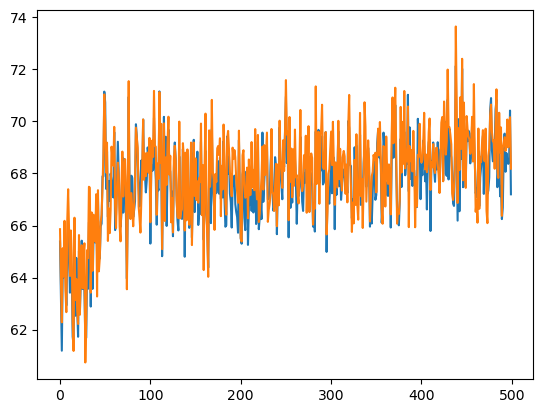

In [41]:
plt.plot(auroc)
plt.plot(ap)

VAE


  0%|          | 0/50 [00:00<?, ?it/s]

0.06626010845648483


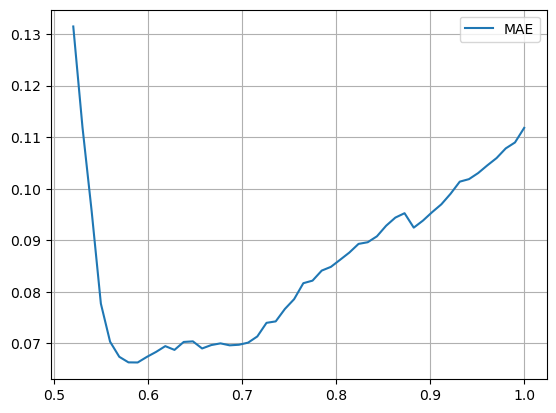

In [42]:
print("VAE")
plot_metrics_by_prop(G, logits.detach().numpy())

---

In [43]:
root = 'data/'
dataset = 'cora'
epochs = 500
lr = 0.01
hidden_size = 32
code_size = 16
model_name = 'vgae'

device = th.device('cpu' if th.cuda.is_available() else 'cpu')

adj = th.load(os.path.join(root, dataset, 'adj.pt')).to_dense().to(device)
features = th.load(os.path.join(root, dataset, 'feats.pt'))

G = nx.from_numpy_matrix(adj.numpy())

features = features.to(device)

edges = get_edges(adj)
train_adj, train_edges, val_edges, val_edges_false, test_edges, test_edges_false = split_edges(edges, adj)

weight_tensor, norm = compute_loss_para(train_adj)
train_adj_norm = normalize_adjacency(train_adj).to(train_adj.device)
feature_size = features.shape[1]

simple_feats = get_simple_feats(G).float()

model = ControlVGAE_v3(feature_size=feature_size, hidden_size=hidden_size, code_size=code_size, sf_size=23)
model.eval_vae()
model.train_control()

model.to(device)

optimizer = th.optim.Adam(model.parameters(), lr=lr)
scheduler = th.optim.lr_scheduler.StepLR(optimizer, step_size=100, gamma=2/3)

print('Total Parameters: {}'.format(sum([p.nelement() for p in model.parameters()])))

losses = []
auroc = []
ap = []

for epoch in range(epochs):
    model.train()
    optimizer.zero_grad()

    z, logits = model(features, train_adj_norm, simple_feats)

    reconstruction_loss = 0
    reconstruction_loss += 1 / 10 * norm * F.binary_cross_entropy(logits.view(-1), train_adj.view(-1), weight=weight_tensor)
    reconstruction_loss += F.binary_cross_entropy(
        logits[train_edges[0]].T[train_edges[1]].T.reshape(-1), train_adj[train_edges[0]].T[train_edges[1]].T.reshape(-1)
    )
    reconstruction_loss += F.binary_cross_entropy(
        logits[val_edges_false[0]].T[val_edges_false[1]].T.reshape(-1), adj[val_edges_false[0]].T[val_edges_false[1]].T.reshape(-1)
    )

    if model_name == 'vgae':
        loss = reconstruction_loss - compute_kl_div(model) + 1/100 * model.constract_loss
        loss.backward()
    else:
        reconstruction_loss.backward()
        
    optimizer.step()

    val_auroc, val_ap = get_scores(val_edges, val_edges_false, logits)

    print('epoch: {:3d} training Loss: {:.4f} validation auroc: {:.2f} % validation ap: {:.2f} % '.format(
        epoch, reconstruction_loss.item(), val_auroc * 100, val_ap * 100)
    )
    
    train_adj, train_edges, val_edges, val_edges_false, test_edges, test_edges_false = split_edges(edges, adj)

    weight_tensor, norm = compute_loss_para(train_adj)
    train_adj_norm = normalize_adjacency(train_adj).to(train_adj.device)
    
    scheduler.step()
    
    losses.append(reconstruction_loss.item())
    auroc.append(val_auroc * 100)
    ap.append(val_ap * 100)

    
test_roc, test_ap = get_scores(test_edges, test_edges_false, logits)

print('training finished !!')
print('test auroc: {:.2f} % test ap: {:.2f} % '.format(test_roc * 100, test_ap * 100))

Total Parameters: 48368


C:\Users\Admin\anaconda3\lib\site-packages\torch\nn\modules\loss.py:536: UserWarning: Using a target size (torch.Size([1, 32])) that is different to the input size (torch.Size([2708, 32])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


epoch:   0 training Loss: 10.2558 validation auroc: 50.84 % validation ap: 53.48 % 
epoch:   1 training Loss: 4.5497 validation auroc: 49.83 % validation ap: 50.53 % 
epoch:   2 training Loss: 4.1665 validation auroc: 52.96 % validation ap: 52.32 % 
epoch:   3 training Loss: 3.5481 validation auroc: 52.67 % validation ap: 52.51 % 
epoch:   4 training Loss: 2.9176 validation auroc: 51.75 % validation ap: 51.89 % 
epoch:   5 training Loss: 2.3461 validation auroc: 51.29 % validation ap: 51.27 % 
epoch:   6 training Loss: 2.0882 validation auroc: 52.81 % validation ap: 51.65 % 
epoch:   7 training Loss: 1.9012 validation auroc: 53.10 % validation ap: 51.95 % 
epoch:   8 training Loss: 1.8617 validation auroc: 56.36 % validation ap: 54.21 % 
epoch:   9 training Loss: 1.7905 validation auroc: 55.46 % validation ap: 52.68 % 
epoch:  10 training Loss: 1.6791 validation auroc: 52.11 % validation ap: 50.63 % 
epoch:  11 training Loss: 1.6334 validation auroc: 56.73 % validation ap: 54.40 % 
epo

epoch:  99 training Loss: 1.4605 validation auroc: 67.62 % validation ap: 64.35 % 
epoch: 100 training Loss: 1.4613 validation auroc: 67.55 % validation ap: 66.43 % 
epoch: 101 training Loss: 1.4598 validation auroc: 67.55 % validation ap: 66.86 % 
epoch: 102 training Loss: 1.4598 validation auroc: 69.04 % validation ap: 67.86 % 
epoch: 103 training Loss: 1.4595 validation auroc: 66.86 % validation ap: 64.52 % 
epoch: 104 training Loss: 1.4590 validation auroc: 67.57 % validation ap: 65.57 % 
epoch: 105 training Loss: 1.4596 validation auroc: 66.94 % validation ap: 64.38 % 
epoch: 106 training Loss: 1.4594 validation auroc: 67.70 % validation ap: 65.48 % 
epoch: 107 training Loss: 1.4600 validation auroc: 67.20 % validation ap: 65.94 % 
epoch: 108 training Loss: 1.4594 validation auroc: 67.84 % validation ap: 66.04 % 
epoch: 109 training Loss: 1.4598 validation auroc: 66.76 % validation ap: 64.37 % 
epoch: 110 training Loss: 1.4606 validation auroc: 66.52 % validation ap: 63.82 % 
epoc

epoch: 198 training Loss: 1.4600 validation auroc: 69.36 % validation ap: 67.93 % 
epoch: 199 training Loss: 1.4603 validation auroc: 68.56 % validation ap: 67.59 % 
epoch: 200 training Loss: 1.4609 validation auroc: 69.05 % validation ap: 66.31 % 
epoch: 201 training Loss: 1.4603 validation auroc: 69.25 % validation ap: 66.67 % 
epoch: 202 training Loss: 1.4584 validation auroc: 69.71 % validation ap: 68.83 % 
epoch: 203 training Loss: 1.4609 validation auroc: 70.26 % validation ap: 68.28 % 
epoch: 204 training Loss: 1.4597 validation auroc: 69.20 % validation ap: 65.78 % 
epoch: 205 training Loss: 1.4592 validation auroc: 67.99 % validation ap: 66.85 % 
epoch: 206 training Loss: 1.4599 validation auroc: 67.87 % validation ap: 67.23 % 
epoch: 207 training Loss: 1.4595 validation auroc: 66.29 % validation ap: 65.19 % 
epoch: 208 training Loss: 1.4608 validation auroc: 67.26 % validation ap: 64.67 % 
epoch: 209 training Loss: 1.4586 validation auroc: 66.71 % validation ap: 65.92 % 
epoc

epoch: 297 training Loss: 1.4580 validation auroc: 67.43 % validation ap: 68.34 % 
epoch: 298 training Loss: 1.4592 validation auroc: 69.29 % validation ap: 68.64 % 
epoch: 299 training Loss: 1.4585 validation auroc: 68.02 % validation ap: 66.91 % 
epoch: 300 training Loss: 1.4577 validation auroc: 70.81 % validation ap: 70.37 % 
epoch: 301 training Loss: 1.4585 validation auroc: 68.89 % validation ap: 66.70 % 
epoch: 302 training Loss: 1.4572 validation auroc: 70.53 % validation ap: 70.39 % 
epoch: 303 training Loss: 1.4586 validation auroc: 68.01 % validation ap: 67.12 % 
epoch: 304 training Loss: 1.4573 validation auroc: 70.24 % validation ap: 69.67 % 
epoch: 305 training Loss: 1.4581 validation auroc: 70.77 % validation ap: 70.16 % 
epoch: 306 training Loss: 1.4579 validation auroc: 71.09 % validation ap: 69.88 % 
epoch: 307 training Loss: 1.4577 validation auroc: 69.58 % validation ap: 70.31 % 
epoch: 308 training Loss: 1.4579 validation auroc: 69.63 % validation ap: 69.76 % 
epoc

epoch: 396 training Loss: 1.4577 validation auroc: 70.82 % validation ap: 70.28 % 
epoch: 397 training Loss: 1.4576 validation auroc: 69.54 % validation ap: 69.46 % 
epoch: 398 training Loss: 1.4580 validation auroc: 69.97 % validation ap: 68.48 % 
epoch: 399 training Loss: 1.4575 validation auroc: 69.30 % validation ap: 68.85 % 
epoch: 400 training Loss: 1.4575 validation auroc: 69.41 % validation ap: 68.94 % 
epoch: 401 training Loss: 1.4569 validation auroc: 70.43 % validation ap: 69.25 % 
epoch: 402 training Loss: 1.4571 validation auroc: 72.92 % validation ap: 73.64 % 
epoch: 403 training Loss: 1.4587 validation auroc: 69.74 % validation ap: 70.35 % 
epoch: 404 training Loss: 1.4574 validation auroc: 69.64 % validation ap: 69.38 % 
epoch: 405 training Loss: 1.4573 validation auroc: 70.53 % validation ap: 70.97 % 
epoch: 406 training Loss: 1.4571 validation auroc: 71.85 % validation ap: 71.94 % 
epoch: 407 training Loss: 1.4569 validation auroc: 71.61 % validation ap: 71.81 % 
epoc

epoch: 495 training Loss: 1.4572 validation auroc: 71.11 % validation ap: 70.68 % 
epoch: 496 training Loss: 1.4568 validation auroc: 69.73 % validation ap: 70.36 % 
epoch: 497 training Loss: 1.4577 validation auroc: 71.58 % validation ap: 73.24 % 
epoch: 498 training Loss: 1.4565 validation auroc: 72.58 % validation ap: 74.51 % 
epoch: 499 training Loss: 1.4577 validation auroc: 70.51 % validation ap: 69.58 % 
training finished !!
test auroc: 76.68 % test ap: 75.18 % 


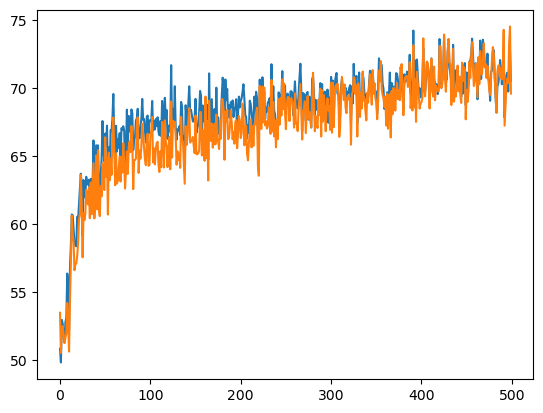

In [44]:
plt.plot(auroc)
plt.plot(ap)

ControlVAE


  0%|          | 0/50 [00:00<?, ?it/s]

0.046077807029527885


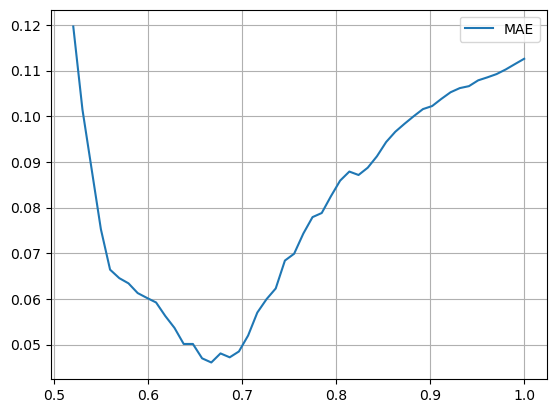

In [45]:
print("ControlVAE")
plot_metrics_by_prop(G, logits.detach().numpy())

In [60]:
(0.06626010845648483 - 0.046077807029527885) / 0.06626010845648483

0.304592037307203

In [46]:
z

tensor([[ 0.1305,  0.4112,  0.0391,  ..., -0.0138,  0.3349,  0.0428],
        [ 0.1073, -0.1196,  0.0021,  ..., -0.4144, -0.1119,  0.0996],
        [-0.0369,  0.2229,  0.1136,  ...,  0.0721,  0.0091, -0.0416],
        ...,
        [ 0.2352, -0.2604,  0.1806,  ...,  0.1529,  0.0596,  0.2273],
        [ 0.1016, -0.0704,  0.0816,  ...,  0.1257,  0.1570,  0.0333],
        [ 0.1802,  0.0668,  0.0357,  ...,  0.1534,  0.1184,  0.0699]],
       grad_fn=<AddBackward0>)

In [47]:
logits

tensor([[0.6468, 0.5278, 0.5269,  ..., 0.4966, 0.5325, 0.5420],
        [0.5278, 0.6500, 0.4720,  ..., 0.4679, 0.5128, 0.5089],
        [0.5269, 0.4720, 0.5553,  ..., 0.5023, 0.4879, 0.4771],
        ...,
        [0.4966, 0.4679, 0.5023,  ..., 0.6308, 0.5068, 0.5049],
        [0.5325, 0.5128, 0.4879,  ..., 0.5068, 0.5550, 0.5505],
        [0.5420, 0.5089, 0.4771,  ..., 0.5049, 0.5505, 0.5639]],
       grad_fn=<SigmoidBackward0>)

---

In [51]:
root = 'data/'
dataset = 'citeseer'
epochs = 500
lr = 0.01
hidden_size = 32
code_size = 16
model_name = 'vgae'

device = th.device('cpu' if th.cuda.is_available() else 'cpu')

adj = th.load(os.path.join(root, dataset, 'adj.pt')).to_dense().to(device)
features = th.load(os.path.join(root, dataset, 'feats.pt'))

G = nx.from_numpy_matrix(adj.numpy())

features = features.to(device)

edges = get_edges(adj)
train_adj, train_edges, val_edges, val_edges_false, test_edges, test_edges_false = split_edges(edges, adj)

weight_tensor, norm = compute_loss_para(train_adj)
train_adj_norm = normalize_adjacency(train_adj).to(train_adj.device)
feature_size = features.shape[1]

simple_feats = get_simple_feats(G).float()

model = ControlVGAE_v3(feature_size=feature_size, hidden_size=hidden_size, code_size=code_size, sf_size=23)
model.train_vae()
model.eval_control()

model.to(device)

optimizer = th.optim.Adam(model.parameters(), lr=lr)
scheduler = th.optim.lr_scheduler.StepLR(optimizer, step_size=150, gamma=1/2)

print('Total Parameters: {}'.format(sum([p.nelement() for p in model.parameters()])))

losses = []
auroc = []
ap = []

for epoch in range(epochs):
    model.train()
    optimizer.zero_grad()

    z, logits = model(features, train_adj_norm, simple_feats)

    reconstruction_loss = 0
    reconstruction_loss += 1 / 10 * norm * F.binary_cross_entropy(logits.view(-1), train_adj.view(-1), weight=weight_tensor)
    reconstruction_loss += F.binary_cross_entropy(
        logits[train_edges[0]].T[train_edges[1]].T.reshape(-1), train_adj[train_edges[0]].T[train_edges[1]].T.reshape(-1)
    )
    reconstruction_loss += F.binary_cross_entropy(
        logits[val_edges_false[0]].T[val_edges_false[1]].T.reshape(-1), adj[val_edges_false[0]].T[val_edges_false[1]].T.reshape(-1)
    )

    if model_name == 'vgae':
        loss = reconstruction_loss - compute_kl_div(model)
        loss.backward()
    else:
        reconstruction_loss.backward()
        
    optimizer.step()

    val_auroc, val_ap = get_scores(val_edges, val_edges_false, logits)

    print('epoch: {:3d} training Loss: {:.4f} validation auroc: {:.2f} % validation ap: {:.2f} % '.format(
        epoch, reconstruction_loss.item(), val_auroc * 100, val_ap * 100)
    )
    
    train_adj, train_edges, val_edges, val_edges_false, test_edges, test_edges_false = split_edges(edges, adj)

    weight_tensor, norm = compute_loss_para(train_adj)
    train_adj_norm = normalize_adjacency(train_adj).to(train_adj.device)
    
    scheduler.step()
    
    losses.append(reconstruction_loss.item())
    auroc.append(val_auroc * 100)
    ap.append(val_ap * 100)

    
test_roc, test_ap = get_scores(test_edges, test_edges_false, logits)

print('training finished !!')
print('test auroc: {:.2f} % test ap: {:.2f} % '.format(test_roc * 100, test_ap * 100))

Total Parameters: 121008
epoch:   0 training Loss: 12.7476 validation auroc: 62.60 % validation ap: 61.06 % 
epoch:   1 training Loss: 65.2326 validation auroc: 57.48 % validation ap: 56.03 % 
epoch:   2 training Loss: 31.7121 validation auroc: 60.77 % validation ap: 57.83 % 
epoch:   3 training Loss: 13.9111 validation auroc: 64.27 % validation ap: 63.43 % 
epoch:   4 training Loss: 6.1755 validation auroc: 66.92 % validation ap: 63.35 % 
epoch:   5 training Loss: 5.7304 validation auroc: 66.08 % validation ap: 63.54 % 
epoch:   6 training Loss: 8.2682 validation auroc: 61.88 % validation ap: 59.40 % 
epoch:   7 training Loss: 8.6756 validation auroc: 63.91 % validation ap: 61.92 % 
epoch:   8 training Loss: 8.1912 validation auroc: 62.66 % validation ap: 60.97 % 
epoch:   9 training Loss: 7.8606 validation auroc: 66.56 % validation ap: 63.91 % 
epoch:  10 training Loss: 6.1870 validation auroc: 64.19 % validation ap: 61.85 % 
epoch:  11 training Loss: 4.2343 validation auroc: 67.78 %

epoch:  99 training Loss: 1.6188 validation auroc: 64.70 % validation ap: 62.73 % 
epoch: 100 training Loss: 1.5993 validation auroc: 67.54 % validation ap: 65.71 % 
epoch: 101 training Loss: 1.6021 validation auroc: 66.27 % validation ap: 63.01 % 
epoch: 102 training Loss: 1.6272 validation auroc: 68.92 % validation ap: 64.93 % 
epoch: 103 training Loss: 1.6537 validation auroc: 67.13 % validation ap: 65.41 % 
epoch: 104 training Loss: 1.6656 validation auroc: 68.72 % validation ap: 65.39 % 
epoch: 105 training Loss: 1.6396 validation auroc: 65.60 % validation ap: 63.82 % 
epoch: 106 training Loss: 1.6215 validation auroc: 67.67 % validation ap: 66.39 % 
epoch: 107 training Loss: 1.6520 validation auroc: 66.42 % validation ap: 61.44 % 
epoch: 108 training Loss: 1.6837 validation auroc: 69.89 % validation ap: 66.89 % 
epoch: 109 training Loss: 1.7031 validation auroc: 66.34 % validation ap: 64.32 % 
epoch: 110 training Loss: 1.6995 validation auroc: 66.50 % validation ap: 64.16 % 
epoc

epoch: 198 training Loss: 1.4869 validation auroc: 68.93 % validation ap: 67.51 % 
epoch: 199 training Loss: 1.5261 validation auroc: 71.15 % validation ap: 69.12 % 
epoch: 200 training Loss: 1.5719 validation auroc: 71.07 % validation ap: 67.30 % 
epoch: 201 training Loss: 1.5793 validation auroc: 70.46 % validation ap: 67.23 % 
epoch: 202 training Loss: 1.5136 validation auroc: 72.20 % validation ap: 69.32 % 
epoch: 203 training Loss: 1.4817 validation auroc: 72.95 % validation ap: 69.97 % 
epoch: 204 training Loss: 1.4895 validation auroc: 69.14 % validation ap: 65.96 % 
epoch: 205 training Loss: 1.5187 validation auroc: 70.41 % validation ap: 67.24 % 
epoch: 206 training Loss: 1.5488 validation auroc: 70.79 % validation ap: 68.31 % 
epoch: 207 training Loss: 1.5124 validation auroc: 71.34 % validation ap: 67.98 % 
epoch: 208 training Loss: 1.4992 validation auroc: 70.29 % validation ap: 67.01 % 
epoch: 209 training Loss: 1.5132 validation auroc: 69.34 % validation ap: 64.57 % 
epoc

epoch: 297 training Loss: 1.4714 validation auroc: 70.81 % validation ap: 68.87 % 
epoch: 298 training Loss: 1.4642 validation auroc: 69.91 % validation ap: 67.78 % 
epoch: 299 training Loss: 1.4810 validation auroc: 69.64 % validation ap: 67.21 % 
epoch: 300 training Loss: 1.4785 validation auroc: 71.23 % validation ap: 69.45 % 
epoch: 301 training Loss: 1.4663 validation auroc: 71.97 % validation ap: 70.90 % 
epoch: 302 training Loss: 1.4609 validation auroc: 71.23 % validation ap: 69.27 % 
epoch: 303 training Loss: 1.4667 validation auroc: 69.29 % validation ap: 66.55 % 
epoch: 304 training Loss: 1.4664 validation auroc: 73.56 % validation ap: 70.98 % 
epoch: 305 training Loss: 1.4643 validation auroc: 72.72 % validation ap: 71.14 % 
epoch: 306 training Loss: 1.4696 validation auroc: 71.19 % validation ap: 68.01 % 
epoch: 307 training Loss: 1.4701 validation auroc: 70.48 % validation ap: 69.61 % 
epoch: 308 training Loss: 1.4639 validation auroc: 74.04 % validation ap: 73.46 % 
epoc

epoch: 396 training Loss: 1.4563 validation auroc: 71.59 % validation ap: 68.92 % 
epoch: 397 training Loss: 1.4565 validation auroc: 72.52 % validation ap: 70.20 % 
epoch: 398 training Loss: 1.4564 validation auroc: 73.56 % validation ap: 71.71 % 
epoch: 399 training Loss: 1.4570 validation auroc: 73.68 % validation ap: 73.95 % 
epoch: 400 training Loss: 1.4570 validation auroc: 73.23 % validation ap: 72.00 % 
epoch: 401 training Loss: 1.4560 validation auroc: 72.57 % validation ap: 71.55 % 
epoch: 402 training Loss: 1.4571 validation auroc: 71.78 % validation ap: 69.53 % 
epoch: 403 training Loss: 1.4571 validation auroc: 72.43 % validation ap: 71.31 % 
epoch: 404 training Loss: 1.4567 validation auroc: 74.44 % validation ap: 72.62 % 
epoch: 405 training Loss: 1.4570 validation auroc: 73.82 % validation ap: 73.93 % 
epoch: 406 training Loss: 1.4576 validation auroc: 72.32 % validation ap: 72.64 % 
epoch: 407 training Loss: 1.4562 validation auroc: 72.70 % validation ap: 71.61 % 
epoc

epoch: 495 training Loss: 1.4548 validation auroc: 74.43 % validation ap: 75.24 % 
epoch: 496 training Loss: 1.4553 validation auroc: 74.34 % validation ap: 72.48 % 
epoch: 497 training Loss: 1.4551 validation auroc: 74.22 % validation ap: 72.90 % 
epoch: 498 training Loss: 1.4545 validation auroc: 75.15 % validation ap: 74.00 % 
epoch: 499 training Loss: 1.4553 validation auroc: 73.86 % validation ap: 72.97 % 
training finished !!
test auroc: 82.09 % test ap: 79.94 % 


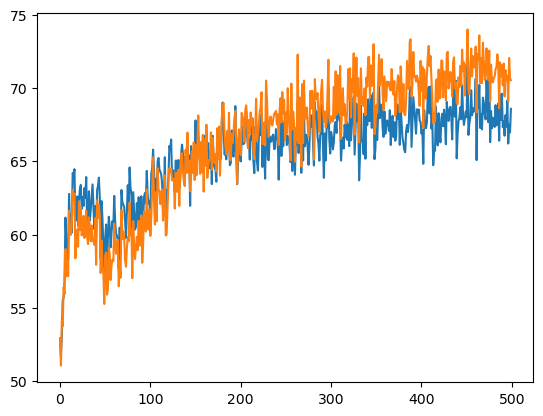

In [62]:
plt.plot(auroc)
plt.plot(ap)

VAE


  0%|          | 0/50 [00:00<?, ?it/s]

0.07208177423475969


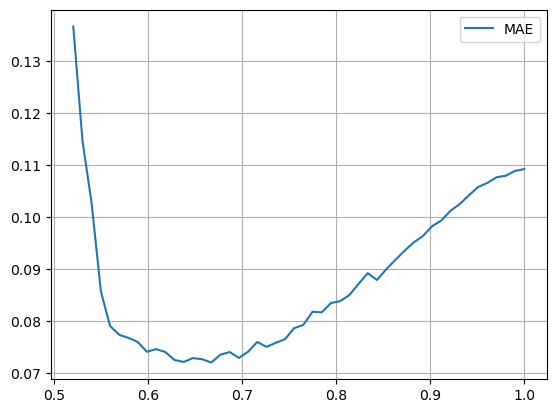

In [53]:
print("VAE")
plot_metrics_by_prop(G, logits.detach().numpy())

In [54]:
root = 'data/'
dataset = 'citeseer'
epochs = 500
lr = 0.01
hidden_size = 32
code_size = 16
model_name = 'vgae'

device = th.device('cpu' if th.cuda.is_available() else 'cpu')

adj = th.load(os.path.join(root, dataset, 'adj.pt')).to_dense().to(device)
features = th.load(os.path.join(root, dataset, 'feats.pt'))

G = nx.from_numpy_matrix(adj.numpy())

features = features.to(device)

edges = get_edges(adj)
train_adj, train_edges, val_edges, val_edges_false, test_edges, test_edges_false = split_edges(edges, adj)

weight_tensor, norm = compute_loss_para(train_adj)
train_adj_norm = normalize_adjacency(train_adj).to(train_adj.device)
feature_size = features.shape[1]

simple_feats = get_simple_feats(G).float()

model = ControlVGAE_v3(feature_size=feature_size, hidden_size=hidden_size, code_size=code_size, sf_size=23)
model.eval_vae()
model.train_control()

model.to(device)

optimizer = th.optim.Adam(model.parameters(), lr=lr)
scheduler = th.optim.lr_scheduler.StepLR(optimizer, step_size=80, gamma=2/3)

print('Total Parameters: {}'.format(sum([p.nelement() for p in model.parameters()])))

losses = []
auroc = []
ap = []

for epoch in range(epochs):
    model.train()
    optimizer.zero_grad()

    z, logits = model(features, train_adj_norm, simple_feats)

    reconstruction_loss = 0
    reconstruction_loss += 1 / 10 * norm * F.binary_cross_entropy(logits.view(-1), train_adj.view(-1), weight=weight_tensor)
    reconstruction_loss += F.binary_cross_entropy(
        logits[train_edges[0]].T[train_edges[1]].T.reshape(-1), train_adj[train_edges[0]].T[train_edges[1]].T.reshape(-1)
    )
    reconstruction_loss += F.binary_cross_entropy(
        logits[val_edges_false[0]].T[val_edges_false[1]].T.reshape(-1), adj[val_edges_false[0]].T[val_edges_false[1]].T.reshape(-1)
    )

    if model_name == 'vgae':
        loss = reconstruction_loss - compute_kl_div(model) + 1/100 * model.constract_loss
        loss.backward()
    else:
        reconstruction_loss.backward()
        
    optimizer.step()

    val_auroc, val_ap = get_scores(val_edges, val_edges_false, logits)

    print('epoch: {:3d} training Loss: {:.4f} validation auroc: {:.2f} % validation ap: {:.2f} % '.format(
        epoch, reconstruction_loss.item(), val_auroc * 100, val_ap * 100)
    )
    
    train_adj, train_edges, val_edges, val_edges_false, test_edges, test_edges_false = split_edges(edges, adj)

    weight_tensor, norm = compute_loss_para(train_adj)
    train_adj_norm = normalize_adjacency(train_adj).to(train_adj.device)
    
    scheduler.step()
    
    losses.append(reconstruction_loss.item())
    auroc.append(val_auroc * 100)
    ap.append(val_ap * 100)

    
test_roc, test_ap = get_scores(test_edges, test_edges_false, logits)

print('training finished !!')
print('test auroc: {:.2f} % test ap: {:.2f} % '.format(test_roc * 100, test_ap * 100))

Total Parameters: 121008


C:\Users\Admin\anaconda3\lib\site-packages\torch\nn\modules\loss.py:536: UserWarning: Using a target size (torch.Size([1, 32])) that is different to the input size (torch.Size([3327, 32])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


epoch:   0 training Loss: 9.1437 validation auroc: 52.91 % validation ap: 52.87 % 
epoch:   1 training Loss: 7.4285 validation auroc: 51.76 % validation ap: 51.06 % 
epoch:   2 training Loss: 3.9981 validation auroc: 53.04 % validation ap: 54.12 % 
epoch:   3 training Loss: 3.1211 validation auroc: 55.53 % validation ap: 53.73 % 
epoch:   4 training Loss: 2.9817 validation auroc: 55.69 % validation ap: 56.42 % 
epoch:   5 training Loss: 2.6279 validation auroc: 56.79 % validation ap: 55.93 % 
epoch:   6 training Loss: 2.2131 validation auroc: 61.16 % validation ap: 59.01 % 
epoch:   7 training Loss: 2.0581 validation auroc: 59.64 % validation ap: 57.15 % 
epoch:   8 training Loss: 2.0956 validation auroc: 59.04 % validation ap: 58.16 % 
epoch:   9 training Loss: 2.0079 validation auroc: 58.29 % validation ap: 57.17 % 
epoch:  10 training Loss: 1.8998 validation auroc: 62.78 % validation ap: 61.64 % 
epoch:  11 training Loss: 1.7597 validation auroc: 60.73 % validation ap: 60.03 % 
epoc

epoch:  99 training Loss: 1.4627 validation auroc: 62.31 % validation ap: 61.71 % 
epoch: 100 training Loss: 1.4626 validation auroc: 61.35 % validation ap: 59.91 % 
epoch: 101 training Loss: 1.4617 validation auroc: 64.17 % validation ap: 61.20 % 
epoch: 102 training Loss: 1.4617 validation auroc: 64.54 % validation ap: 63.24 % 
epoch: 103 training Loss: 1.4612 validation auroc: 65.80 % validation ap: 65.28 % 
epoch: 104 training Loss: 1.4622 validation auroc: 64.40 % validation ap: 62.34 % 
epoch: 105 training Loss: 1.4637 validation auroc: 62.96 % validation ap: 60.69 % 
epoch: 106 training Loss: 1.4622 validation auroc: 63.80 % validation ap: 62.89 % 
epoch: 107 training Loss: 1.4613 validation auroc: 62.31 % validation ap: 60.91 % 
epoch: 108 training Loss: 1.4605 validation auroc: 65.00 % validation ap: 64.54 % 
epoch: 109 training Loss: 1.4621 validation auroc: 65.24 % validation ap: 63.13 % 
epoch: 110 training Loss: 1.4614 validation auroc: 64.45 % validation ap: 62.94 % 
epoc

epoch: 198 training Loss: 1.4596 validation auroc: 66.67 % validation ap: 67.19 % 
epoch: 199 training Loss: 1.4594 validation auroc: 66.06 % validation ap: 66.11 % 
epoch: 200 training Loss: 1.4594 validation auroc: 65.00 % validation ap: 65.42 % 
epoch: 201 training Loss: 1.4596 validation auroc: 66.39 % validation ap: 68.32 % 
epoch: 202 training Loss: 1.4593 validation auroc: 67.39 % validation ap: 68.07 % 
epoch: 203 training Loss: 1.4584 validation auroc: 66.18 % validation ap: 67.79 % 
epoch: 204 training Loss: 1.4598 validation auroc: 66.26 % validation ap: 66.34 % 
epoch: 205 training Loss: 1.4589 validation auroc: 67.41 % validation ap: 68.44 % 
epoch: 206 training Loss: 1.4592 validation auroc: 68.41 % validation ap: 68.83 % 
epoch: 207 training Loss: 1.4591 validation auroc: 66.78 % validation ap: 67.88 % 
epoch: 208 training Loss: 1.4589 validation auroc: 66.03 % validation ap: 65.91 % 
epoch: 209 training Loss: 1.4590 validation auroc: 66.53 % validation ap: 67.82 % 
epoc

epoch: 297 training Loss: 1.4577 validation auroc: 70.01 % validation ap: 71.94 % 
epoch: 298 training Loss: 1.4586 validation auroc: 66.52 % validation ap: 67.92 % 
epoch: 299 training Loss: 1.4586 validation auroc: 65.54 % validation ap: 67.61 % 
epoch: 300 training Loss: 1.4586 validation auroc: 67.01 % validation ap: 68.06 % 
epoch: 301 training Loss: 1.4592 validation auroc: 66.63 % validation ap: 68.09 % 
epoch: 302 training Loss: 1.4577 validation auroc: 65.82 % validation ap: 67.72 % 
epoch: 303 training Loss: 1.4581 validation auroc: 66.30 % validation ap: 70.09 % 
epoch: 304 training Loss: 1.4589 validation auroc: 67.45 % validation ap: 67.93 % 
epoch: 305 training Loss: 1.4580 validation auroc: 67.69 % validation ap: 71.15 % 
epoch: 306 training Loss: 1.4584 validation auroc: 66.94 % validation ap: 68.18 % 
epoch: 307 training Loss: 1.4577 validation auroc: 68.86 % validation ap: 70.89 % 
epoch: 308 training Loss: 1.4580 validation auroc: 68.33 % validation ap: 70.63 % 
epoc

epoch: 396 training Loss: 1.4572 validation auroc: 68.30 % validation ap: 70.62 % 
epoch: 397 training Loss: 1.4578 validation auroc: 68.55 % validation ap: 69.76 % 
epoch: 398 training Loss: 1.4572 validation auroc: 67.80 % validation ap: 68.79 % 
epoch: 399 training Loss: 1.4565 validation auroc: 67.70 % validation ap: 71.87 % 
epoch: 400 training Loss: 1.4571 validation auroc: 66.90 % validation ap: 69.85 % 
epoch: 401 training Loss: 1.4573 validation auroc: 67.16 % validation ap: 71.47 % 
epoch: 402 training Loss: 1.4573 validation auroc: 64.83 % validation ap: 67.28 % 
epoch: 403 training Loss: 1.4571 validation auroc: 68.51 % validation ap: 71.28 % 
epoch: 404 training Loss: 1.4572 validation auroc: 67.45 % validation ap: 69.99 % 
epoch: 405 training Loss: 1.4576 validation auroc: 67.27 % validation ap: 69.29 % 
epoch: 406 training Loss: 1.4574 validation auroc: 67.67 % validation ap: 70.90 % 
epoch: 407 training Loss: 1.4568 validation auroc: 69.73 % validation ap: 72.13 % 
epoc

epoch: 495 training Loss: 1.4562 validation auroc: 69.15 % validation ap: 70.84 % 
epoch: 496 training Loss: 1.4569 validation auroc: 66.22 % validation ap: 69.10 % 
epoch: 497 training Loss: 1.4565 validation auroc: 67.51 % validation ap: 72.07 % 
epoch: 498 training Loss: 1.4574 validation auroc: 66.98 % validation ap: 70.67 % 
epoch: 499 training Loss: 1.4565 validation auroc: 68.59 % validation ap: 70.55 % 
training finished !!
test auroc: 76.28 % test ap: 76.44 % 


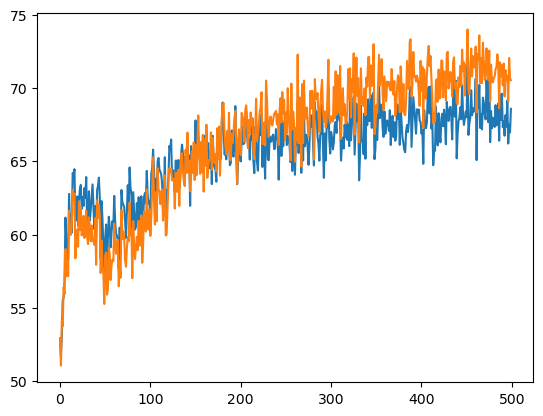

In [57]:
plt.plot(auroc)
plt.plot(ap)

ControlVAE


  0%|          | 0/50 [00:00<?, ?it/s]

0.059126437990587116


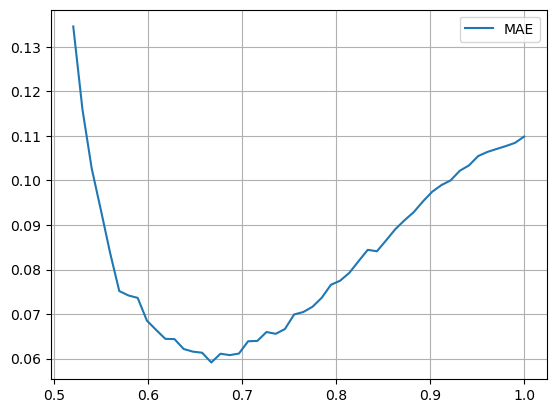

In [63]:
print("ControlVAE")
plot_metrics_by_prop(G, logits.detach().numpy())

In [58]:
z

tensor([[-0.1546,  0.2862,  0.2879,  ..., -0.1009, -0.0849, -0.5253],
        [ 0.0876, -0.0546, -0.0366,  ...,  0.0867,  0.0474, -0.0706],
        [-0.1931, -0.0416, -0.1343,  ..., -0.1917, -0.1066,  0.1073],
        ...,
        [-0.0098, -0.1653, -0.0820,  ...,  0.0052, -0.0124,  0.1512],
        [-0.1147,  0.0847,  0.0215,  ...,  0.2010, -0.0814,  0.0455],
        [ 0.1172,  0.1710,  0.0962,  ...,  0.0985,  0.0402,  0.1719]],
       grad_fn=<AddBackward0>)

In [59]:
logits

tensor([[0.7163, 0.4810, 0.4806,  ..., 0.4568, 0.5285, 0.5020],
        [0.4810, 0.5648, 0.4997,  ..., 0.4819, 0.5079, 0.5095],
        [0.4806, 0.4997, 0.6840,  ..., 0.5295, 0.4492, 0.5104],
        ...,
        [0.4568, 0.4819, 0.5295,  ..., 0.5725, 0.4980, 0.5046],
        [0.5285, 0.5079, 0.4492,  ..., 0.4980, 0.5756, 0.4901],
        [0.5020, 0.5095, 0.5104,  ..., 0.5046, 0.4901, 0.5653]],
       grad_fn=<SigmoidBackward0>)

In [61]:
(0.07208177423475969 - 0.0601387563956529) / 0.07208177423475969

0.16568706813750367